# Beach Crowd Prediction — TFT: Full vs Split-Gap Datasets

Compares **NeuralForecast TFT** vs **PyTorch-Forecasting TFT** using daytime-only data
with sequential `time_idx`.

**Two dataset groups:**
1. **Full** — all daytime data as one continuous sequence (no gap)
2. **SplitGap** — Early (first 40%) + Late (last 40%) concatenated, skipping the middle 20%

This simulates comparing a complete dataset vs having **2022 + 2025 data** with missing years in between.
When real 2022 and 2025 data arrives, just replace the Early/Late splits.

All plots use **real datetime labels** on the x-axis.


In [1]:
CACHE_DIR = "cache/predictions"
COUNTING_MODEL = "bayesian_vgg19"
SAVE_DIR = "models/tft_split_gap"
from pathlib import Path

save_dir = Path(SAVE_DIR)
save_dir.mkdir(parents=True, exist_ok=True)

# === QUICK TEST FILTERS ===
SAMPLE_FRAC = 1
MAX_BEACHES = None
BEACH_NAMES = None

# === GPU ===
GPU_NF = 0
GPU_PF = 1

# === NF TFT PARAMETERS (tuned from sensitivity analysis) ===
MAX_STEPS = 1500
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
INPUT_SIZE = 48
HORIZON = 12
NF_HIDDEN_SIZE = 128
NF_N_HEAD = 4
NF_SCALER = "robust"

NIGHT_START = 20
NIGHT_END = 6


In [2]:
import subprocess, sys
for pkg in ["neuralforecast", "utilsforecast"]:
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip3.13 install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip3.13 install --upgrade pip


In [3]:
import json, time, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')

import torch
from neuralforecast import NeuralForecast
from neuralforecast.models import TFT
from neuralforecast.losses.pytorch import MAE

if torch.cuda.is_available():
    n_gpus = torch.cuda.device_count()
    ACCELERATOR = 'gpu'
    NF_DEVICES = [GPU_NF] if n_gpus > 1 else [0]
    PF_DEVICES = [GPU_PF] if n_gpus > 1 else [0]
    for i in range(n_gpus):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    ACCELERATOR = 'mps'
    NF_DEVICES = [0]
    PF_DEVICES = [0]
else:
    ACCELERATOR = 'cpu'
    NF_DEVICES = [0]
    PF_DEVICES = [0]

print(f"Accelerator: {ACCELERATOR} | NF GPU: {NF_DEVICES} | PF GPU: {PF_DEVICES}")
print(f"PyTorch: {torch.__version__}")


Accelerator: mps | NF GPU: [0] | PF GPU: [0]
PyTorch: 2.9.1


In [4]:
def calc_metrics(y_true, y_pred, max_count):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    rel_mae = (mae / max_count) * 100 if max_count > 0 else 0
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'RelMAE': rel_mae}

def eval_per_beach(df, y_pred, beach_col='unique_id'):
    results = []
    for b in df[beach_col].unique():
        mask = df[beach_col] == b
        if mask.sum() < 3:
            continue
        y_true = df.loc[mask, 'y'].values if 'y' in df.columns else df.loc[mask, 'count'].values
        y_p = y_pred[mask.values] if hasattr(mask, 'values') else y_pred[mask]
        max_count = y_true.max()
        m = calc_metrics(y_true, y_p, max_count)
        m['camera'] = b
        m['max_count'] = max_count
        m['n'] = mask.sum()
        results.append(m)
    return pd.DataFrame(results)

## Load and Prepare Data

In [5]:
def load_cache(cache_dir, model):
    cache_path = Path(cache_dir) / model
    records = []
    for jf in cache_path.rglob("*.json"):
        try:
            with open(jf) as f:
                r = json.load(f)
            if 'error' not in r:
                records.append(r)
        except: pass
    
    rows = []
    for r in records:
        row = {
            'beach': r.get('beach') or r.get('beach_folder'),
            'beach_folder': r.get('beach_folder'),
            'datetime': r.get('datetime'),
            'count': r.get('count')
        }
        for k, v in r.get('weather', {}).items():
            row[k] = v
        rows.append(row)
    
    df = pd.DataFrame(rows)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime').reset_index(drop=True)
    return df

df_raw = load_cache(CACHE_DIR, COUNTING_MODEL)
print(f"Loaded: {len(df_raw)} rows, {df_raw['beach'].nunique()} beaches")

Loaded: 169241 rows, 41 beaches


In [6]:
EXCLUDE = ['livecampro/001', 'livecampro/011', 'livecampro/018', 'livecampro/021',
    'livecampro/030', 'livecampro/039', 'livecampro/070', 'MultimediaTres/PortAndratx',
    'SeeTheWorld/mallorca_pancam', 'skyline/es-pujols']
EXCLUDE_PREFIX = ['ibred', 'ClubNauticSoller', 'Guenthoer', 'youtube']

before = len(df_raw)
df_raw = df_raw[~df_raw['beach_folder'].isin(EXCLUDE)]
for p in EXCLUDE_PREFIX:
    df_raw = df_raw[~df_raw['beach_folder'].str.startswith(p, na=False)]
print(f"Filtered: {before} -> {len(df_raw)}")

Filtered: 169241 -> 70501


In [7]:
if SAMPLE_FRAC < 1.0:
    df_raw = df_raw.sample(frac=SAMPLE_FRAC, random_state=42).sort_values('datetime').reset_index(drop=True)

if BEACH_NAMES:
    df_raw = df_raw[df_raw['beach_folder'].isin(BEACH_NAMES)].reset_index(drop=True)
    print(f"Filtered to {len(BEACH_NAMES)} specific beaches: {BEACH_NAMES}")
elif MAX_BEACHES:
    top = df_raw['beach_folder'].value_counts().head(MAX_BEACHES).index.tolist()
    df_raw = df_raw[df_raw['beach_folder'].isin(top)].reset_index(drop=True)
    print(f"Top {MAX_BEACHES} beaches by data: {top}")

print(f"Final: {len(df_raw)} rows, {df_raw['beach_folder'].nunique()} beaches")


Final: 70501 rows, 16 beaches


In [8]:
df = df_raw.copy()
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
df['is_night'] = ((df['hour'] >= NIGHT_START) | (df['hour'] <= NIGHT_END)).astype(int)

WEATHER_COLS = [c for c in df.columns if c.startswith('ae_') or c.startswith('om_')]
TEMPORAL_COLS = ['hour', 'day_of_week', 'month', 'is_weekend', 'is_summer', 'is_night']
ALL_FEATURES = WEATHER_COLS + TEMPORAL_COLS

df = df.dropna(subset=ALL_FEATURES + ['count']).reset_index(drop=True)
good = df.groupby('beach')['count'].max()
good = good[good > 20].index.tolist()
df = df[df['beach'].isin(good)].reset_index(drop=True)

print(f"After cleaning: {len(df)} rows, {len(good)} beaches")
print(f"Features: {len(ALL_FEATURES)}")

After cleaning: 70090 rows, 14 beaches
Features: 35


## Daytime Dataset

In [9]:
ds_daytime = df[df['is_night'] == 0].copy().reset_index(drop=True)

print(f"Daytime dataset: {len(ds_daytime)} rows, {ds_daytime['beach'].nunique()} beaches")
print(f"Hours range: {ds_daytime['hour'].min()} to {ds_daytime['hour'].max()}")
print(f"Date range: {ds_daytime['datetime'].min().date()} to {ds_daytime['datetime'].max().date()}")


Daytime dataset: 37643 rows, 14 beaches
Hours range: 7 to 19
Date range: 2022-07-14 to 2023-01-24


### Data Overview Visualization

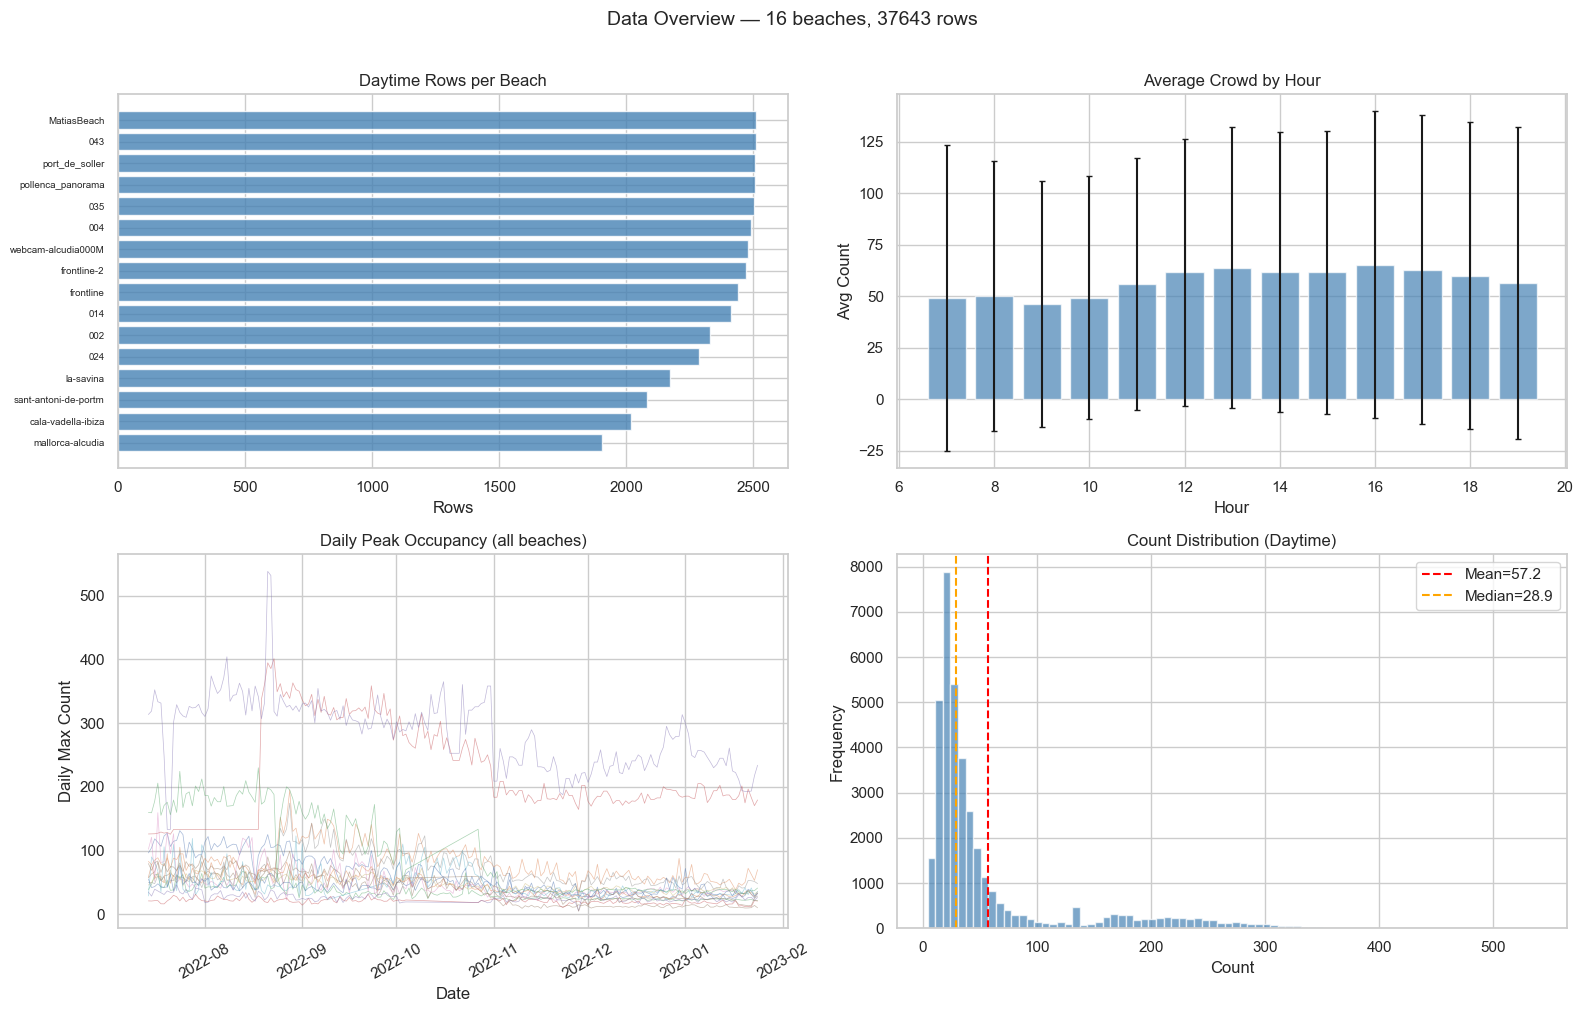

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Rows per beach
beach_counts = ds_daytime.groupby('beach_folder').size().sort_values(ascending=True)
colors = ['coral' if b in (BEACH_NAMES or []) else 'steelblue' for b in beach_counts.index]
axes[0,0].barh(range(len(beach_counts)), beach_counts.values, color=colors if BEACH_NAMES else 'steelblue', alpha=0.8)
axes[0,0].set_yticks(range(len(beach_counts)))
axes[0,0].set_yticklabels([b.split('/')[-1][:20] for b in beach_counts.index], fontsize=7)
axes[0,0].set_xlabel('Rows')
axes[0,0].set_title('Daytime Rows per Beach')

# 2. Hourly distribution
hourly = ds_daytime.groupby('hour')['count'].agg(['mean', 'std'])
axes[0,1].bar(hourly.index, hourly['mean'], yerr=hourly['std'], color='steelblue', alpha=0.7, capsize=2)
axes[0,1].set_xlabel('Hour')
axes[0,1].set_ylabel('Avg Count')
axes[0,1].set_title('Average Crowd by Hour')

# 3. Daily pattern over time (one line per beach)
daily = ds_daytime.groupby([ds_daytime['datetime'].dt.date, 'beach_folder'])['count'].max().reset_index()
daily.columns = ['date', 'beach', 'max_count']
daily['date'] = pd.to_datetime(daily['date'])
for beach in daily['beach'].unique():
    sub = daily[daily['beach'] == beach]
    axes[1,0].plot(sub['date'], sub['max_count'], linewidth=0.5, alpha=0.5)
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Daily Max Count')
axes[1,0].set_title('Daily Peak Occupancy (all beaches)')
axes[1,0].tick_params(axis='x', rotation=30)

# 4. Count distribution
axes[1,1].hist(ds_daytime['count'], bins=80, color='steelblue', alpha=0.7, edgecolor='white')
axes[1,1].axvline(ds_daytime['count'].mean(), color='red', linestyle='--', label=f"Mean={ds_daytime['count'].mean():.1f}")
axes[1,1].axvline(ds_daytime['count'].median(), color='orange', linestyle='--', label=f"Median={ds_daytime['count'].median():.1f}")
axes[1,1].set_xlabel('Count')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Count Distribution (Daytime)')
axes[1,1].legend()

plt.suptitle(f"Data Overview — {ds_daytime['beach_folder'].nunique()} beaches, {len(ds_daytime)} rows", fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig(save_dir / 'data_overview.png', dpi=150)
plt.show()


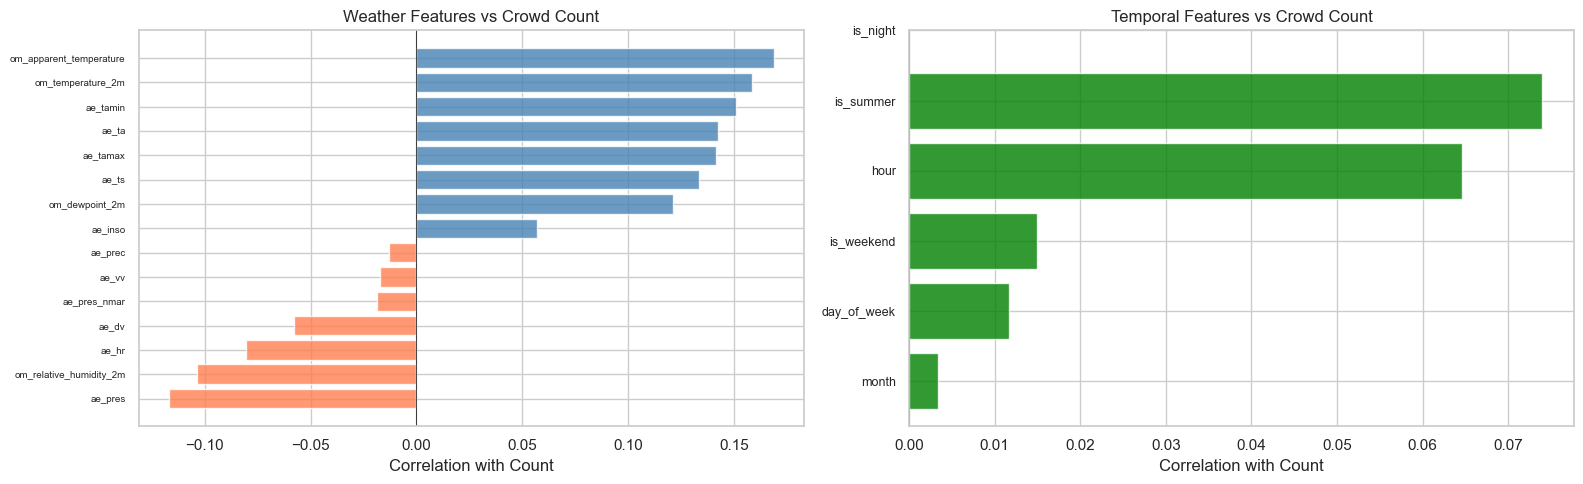

In [11]:
# Weather feature correlations with count
feat_corr = ds_daytime[['count'] + WEATHER_COLS[:15]].corr()['count'].drop('count').sort_values()
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].barh(range(len(feat_corr)), feat_corr.values, color=['coral' if v < 0 else 'steelblue' for v in feat_corr.values], alpha=0.8)
axes[0].set_yticks(range(len(feat_corr)))
axes[0].set_yticklabels(feat_corr.index, fontsize=7)
axes[0].set_xlabel('Correlation with Count')
axes[0].set_title('Weather Features vs Crowd Count')
axes[0].axvline(0, color='black', linewidth=0.5)

# Temporal feature importance
temp_corr = ds_daytime[['count'] + TEMPORAL_COLS].corr()['count'].drop('count').sort_values()
axes[1].barh(range(len(temp_corr)), temp_corr.values, color=['coral' if v < 0 else 'green' for v in temp_corr.values], alpha=0.8)
axes[1].set_yticks(range(len(temp_corr)))
axes[1].set_yticklabels(temp_corr.index, fontsize=9)
axes[1].set_xlabel('Correlation with Count')
axes[1].set_title('Temporal Features vs Crowd Count')
axes[1].axvline(0, color='black', linewidth=0.5)

plt.tight_layout()
plt.savefig(save_dir / 'feature_correlations.png', dpi=150)
plt.show()


## Build Two Dataset Groups

1. **Full** — entire daytime dataset, continuous
2. **SplitGap** — Early (first 40%) + Late (last 40%) concatenated into one sequence, gap removed

Train/Val/Test splits are handled internally by NeuralForecast (`cross_validation` with `n_windows` + `h`)
and PyTorch-Forecasting (`TimeSeriesDataSet`).


In [12]:
ds = ds_daytime.sort_values(['beach_folder', 'datetime']).reset_index(drop=True)
n = len(ds)

full_data = ds.copy()

early = ds.iloc[:int(n * 0.4)].copy()
late = ds.iloc[int(n * 0.6):].copy()
gap_start = ds.iloc[int(n * 0.4)]['datetime']
gap_end = ds.iloc[int(n * 0.6)]['datetime']
splitgap_data = pd.concat([early, late]).sort_values(['beach_folder', 'datetime']).reset_index(drop=True)

dataset_groups = {
    'Full': {'name': 'Full', 'data': full_data},
    'SplitGap': {'name': 'SplitGap', 'data': splitgap_data},
}

for ds_info in dataset_groups.values():
    name = ds_info['name']
    d = ds_info['data']
    print(f"\n{name}:")
    print(f"  Date range: {d['datetime'].min().date()} to {d['datetime'].max().date()}")
    print(f"  Total: {len(d)} | Beaches: {d['beach_folder'].nunique()}")

print(f"\nSplitGap removed: {gap_start.date()} to {gap_end.date()} ({len(ds) - len(splitgap_data)} rows)")



Full:
  Date range: 2022-07-14 to 2023-01-24
  Total: 37643 | Beaches: 16

SplitGap:
  Date range: 2022-07-14 to 2023-01-24
  Total: 30115 | Beaches: 14

SplitGap removed: 2022-07-25 to 2022-08-16 (7528 rows)


### Dataset Overview Visualization

Distribution comparison between Full and SplitGap datasets.


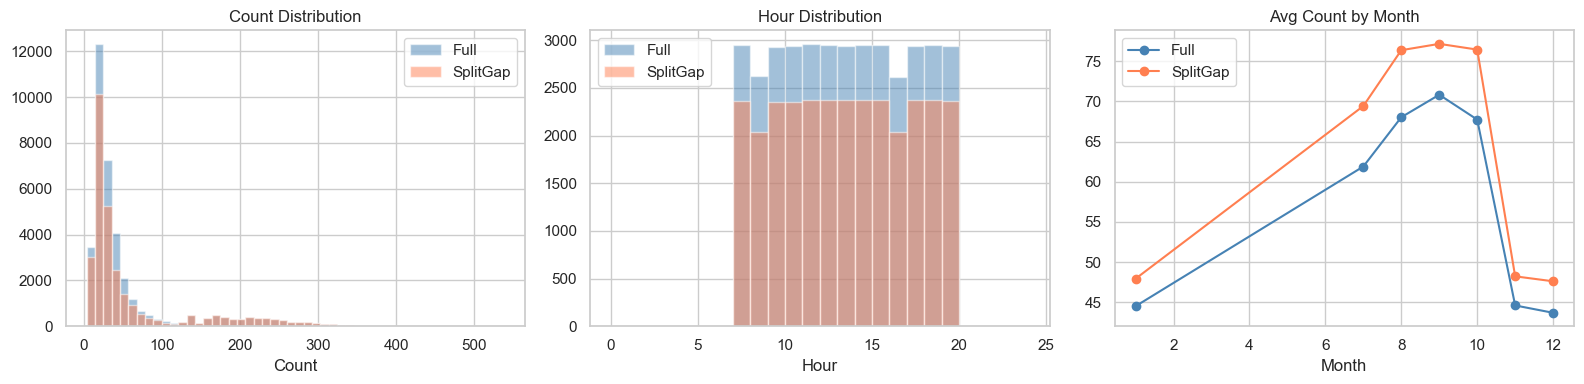

In [13]:


# Legend for splits
from matplotlib.lines import Line2D

# Stats comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for i, (name, ds_info) in enumerate(dataset_groups.items()):
    d = ds_info['data']
    color = 'steelblue' if name == 'Full' else 'coral'

    axes[0].hist(d['count'], bins=50, alpha=0.5, label=name, color=color, edgecolor='white')
    axes[1].hist(d['hour'], bins=range(25), alpha=0.5, label=name, color=color, edgecolor='white')

    monthly = d.groupby(d['datetime'].dt.month)['count'].mean()
    axes[2].plot(monthly.index, monthly.values, 'o-', label=name, color=color)

axes[0].set_xlabel('Count'); axes[0].set_title('Count Distribution'); axes[0].legend()
axes[1].set_xlabel('Hour'); axes[1].set_title('Hour Distribution'); axes[1].legend()
axes[2].set_xlabel('Month'); axes[2].set_title('Avg Count by Month'); axes[2].legend()
plt.tight_layout()
plt.savefig(save_dir / 'dataset_comparison.png', dpi=150)
plt.show()


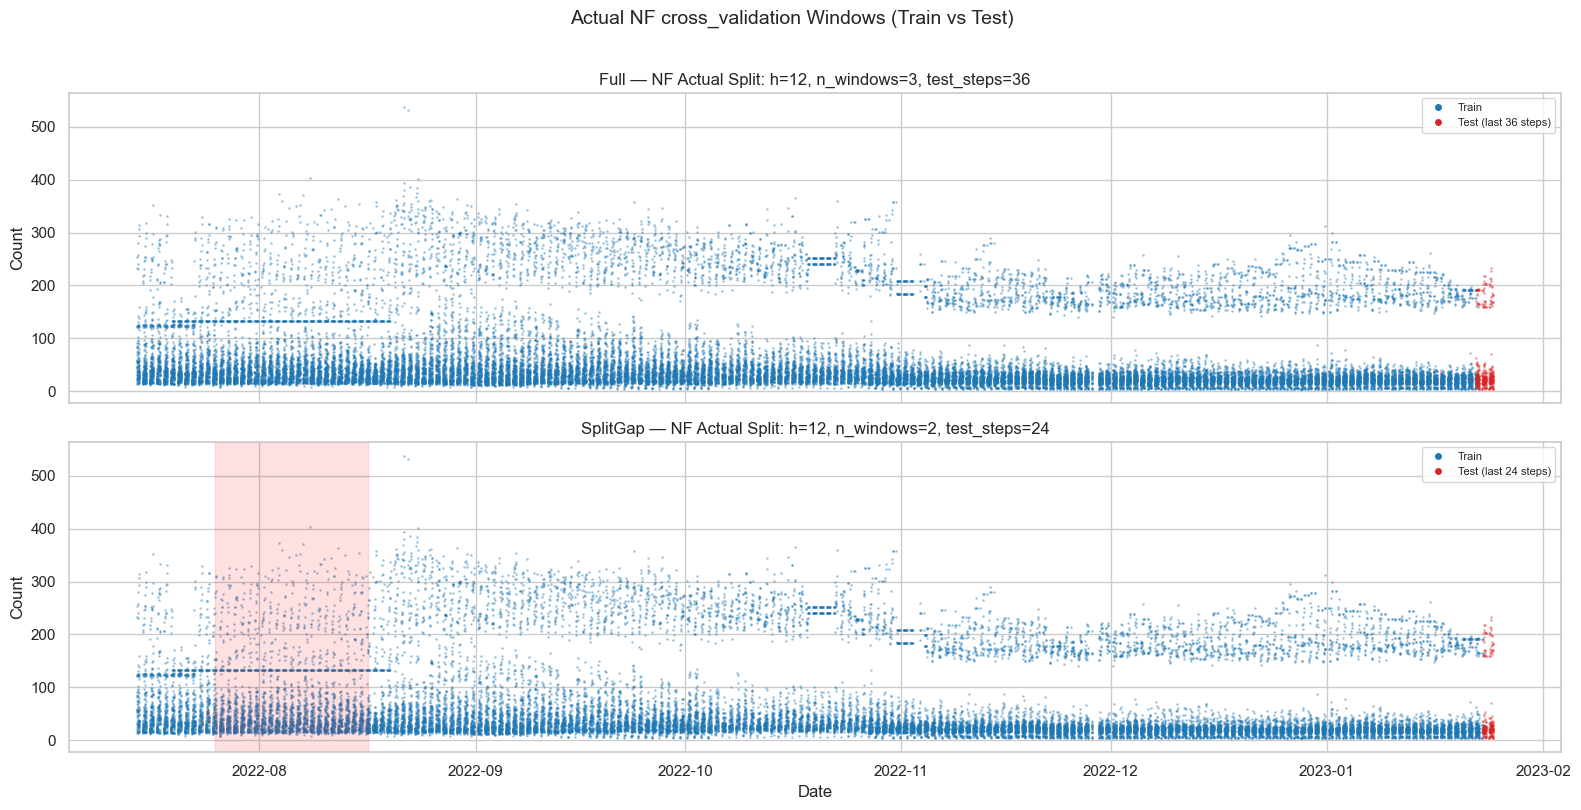

In [14]:
# Preview of actual NF cross_validation windows
# NF uses the last (n_windows * h) steps as test, everything before is train

fig, axes = plt.subplots(len(dataset_groups), 1, figsize=(16, 4 * len(dataset_groups)), sharex=True)
if len(dataset_groups) == 1:
    axes = [axes]

for ax, (ds_name, ds_info) in zip(axes, dataset_groups.items()):
    d = ds_info['data'].sort_values(['beach_folder', 'datetime']).reset_index(drop=True)
    series_len = d.groupby('beach_folder').size()
    min_len = series_len.min()

    h = min(HORIZON, min_len // 4)
    n_windows = max(1, (min_len // 4) // h)
    if n_windows > 3:
        n_windows = 3
    test_steps = n_windows * h

    for uid in d['beach_folder'].unique():
        grp = d[d['beach_folder'] == uid].sort_values('datetime')
        n_pts = len(grp)
        cutoff = n_pts - test_steps
        train_part = grp.iloc[:cutoff]
        test_part = grp.iloc[cutoff:]
        ax.scatter(train_part['datetime'], train_part['count'], s=1, alpha=0.3, c='tab:blue')
        ax.scatter(test_part['datetime'], test_part['count'], s=1, alpha=0.3, c='tab:red')

    if ds_name == 'SplitGap':
        ax.axvspan(gap_start, gap_end, alpha=0.12, color='red', label=f'Gap ({gap_start.date()}\u2192{gap_end.date()})')

    ax.set_ylabel('Count')
    ax.set_title(f'{ds_name} \u2014 NF Actual Split: h={h}, n_windows={n_windows}, test_steps={test_steps}')
    from matplotlib.lines import Line2D
    legend_els = [
        Line2D([0],[0], marker='o', color='w', markerfacecolor='tab:blue', markersize=6, label='Train'),
        Line2D([0],[0], marker='o', color='w', markerfacecolor='tab:red', markersize=6, label=f'Test (last {test_steps} steps)'),
    ]
    ax.legend(handles=legend_els, loc='upper right', fontsize=8)

axes[-1].set_xlabel('Date')
plt.suptitle('Actual NF cross_validation Windows (Train vs Test)', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig(save_dir / 'data_split_distribution.png', dpi=150)
plt.show()


## Prepare NF Data with Sequential `time_idx`

Each beach gets a continuous integer index (no gaps even in SplitGap).
A `time_idx → datetime` mapping is stored for plotting.
Test/val sizes are derived from `h` and `n_windows` to match NF's actual logic.


In [15]:
def prepare_nf_with_mapping(ds_info):
    all_data = ds_info['data'].sort_values(['beach_folder', 'datetime']).reset_index(drop=True)
    all_data['unique_id'] = all_data['beach_folder']
    all_data['y'] = all_data['count']
    all_data['ds'] = all_data.groupby('unique_id').cumcount()

    dt_map = all_data.set_index(['unique_id', 'ds'])['datetime'].to_dict()

    series_len = all_data.groupby('unique_id').size()
    min_len = series_len.min()
    h = min(HORIZON, min_len // 4)
    n_windows = max(1, (min_len // 4) // h)
    if n_windows > 3:
        n_windows = 3
    test_size = n_windows * h
    val_size = h  # one horizon window for internal validation

    cols = ['unique_id', 'ds', 'y'] + [c for c in ALL_FEATURES if c in all_data.columns]
    nf_df = all_data[cols].copy()

    for col in nf_df.select_dtypes(include=[np.number]).columns:
        if col != 'ds':
            nf_df[col] = nf_df.groupby('unique_id')[col].transform(
                lambda x: x.interpolate(method='linear').ffill().bfill()
            )

    return nf_df, dt_map, h, n_windows, val_size

nf_data = {}
for name, ds_info in dataset_groups.items():
    nf_df, dt_map, h, n_win, val_sz = prepare_nf_with_mapping(ds_info)
    nf_data[name] = {'nf_df': nf_df, 'dt_map': dt_map, 'h': h, 'n_windows': n_win, 'val_size': val_sz}
    print(f"{name}: {len(nf_df)} rows | h={h} | n_windows={n_win} | val_size={val_sz}")


Full: 37643 rows | h=12 | n_windows=3 | val_size=12
SplitGap: 30115 rows | h=12 | n_windows=2 | val_size=12


## NeuralForecast TFT — Full vs SplitGap

In [16]:
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch").setLevel(logging.WARNING)

all_results = []
all_cv_details = []

def run_nf_tft(name, nf_df, dt_map, h, n_windows, val_size):
    print(f"\n{'=' * 60}")
    print(f"NF_TFT \u2014 {name} | h={h} | n_windows={n_windows} | val_size={val_size} | series={nf_df['unique_id'].nunique()}")
    print(f"{'=' * 60}")

    try:
        t0 = time.time()
        model = TFT(
            h=h, input_size=INPUT_SIZE,
            hidden_size=NF_HIDDEN_SIZE, n_head=NF_N_HEAD,
            max_steps=MAX_STEPS, early_stop_patience_steps=10,
            learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE,
            scaler_type=NF_SCALER, random_seed=42,
            accelerator=ACCELERATOR, devices=NF_DEVICES,
            loss=MAE(), hist_exog_list=ALL_FEATURES, val_check_steps=50,
            enable_progress_bar=False,
        )
        nf = NeuralForecast(models=[model], freq=1)
        cv = nf.cross_validation(df=nf_df, val_size=val_size, n_windows=n_windows, step_size=h)
        elapsed = time.time() - t0

        pred_col = [c for c in cv.columns if c not in ['unique_id', 'ds', 'cutoff', 'y']][0]
        cv['pred'] = np.clip(cv[pred_col].values, 0, None)
        cv['datetime'] = cv.apply(lambda r: dt_map.get((r['unique_id'], int(r['ds'])), None), axis=1)

        m = calc_metrics(cv['y'].values, cv['pred'].values, cv['y'].max())

        beach_res = []
        for b in cv['unique_id'].unique():
            bm = cv[cv['unique_id'] == b]
            if len(bm) < 3:
                continue
            bmetrics = calc_metrics(bm['y'].values, bm['pred'].values, bm['y'].max())
            bmetrics['beach'] = b
            beach_res.append(bmetrics)
        beach_df = pd.DataFrame(beach_res)
        avg_rel = beach_df['RelMAE'].mean() if len(beach_df) > 0 else m['RelMAE']

        all_results.append({
            'Model': 'NF_TFT', 'Dataset': name, 'MAE': m['MAE'], 'RMSE': m['RMSE'],
            'R2': m['R2'], 'AvgRelMAE': avg_rel, 'Time': elapsed,
        })
        all_cv_details.append({
            'name': name, 'model': 'NF_TFT', 'merged': cv, 'beach_df': beach_df,
        })
        print(f"  {elapsed:.0f}s | MAE={m['MAE']:.1f} | RelMAE={avg_rel:.1f}% | R2={m['R2']:.3f}")
    except Exception as e:
        print(f"  ERROR: {e}")
        import traceback; traceback.print_exc()

for name, d in nf_data.items():
    run_nf_tft(name, d['nf_df'], d['dt_map'], d['h'], d['n_windows'], d['val_size'])


Seed set to 42



NF_TFT — Full | h=12 | n_windows=3 | val_size=12 | series=16


SystemExit: 1

## NF Results

In [17]:
results_df = pd.DataFrame(all_results)
save_dir = Path(SAVE_DIR)
save_dir.mkdir(parents=True, exist_ok=True)
results_df.to_csv(save_dir / 'nf_results.csv', index=False)
print(results_df.to_string(index=False))


Empty DataFrame
Columns: []
Index: []


### Predictions vs Actual — NF TFT

In [ ]:
for detail in all_cv_details:
    merged = detail['merged']
    name = detail['name']

    beaches = merged.groupby('unique_id').size().nlargest(4).index.tolist()
    fig, axes = plt.subplots(len(beaches), 1, figsize=(16, 4 * len(beaches)), sharex=False)
    if len(beaches) == 1:
        axes = [axes]

    for ax, beach in zip(axes, beaches):
        sub = merged[merged['unique_id'] == beach].sort_values('ds')
        x = pd.to_datetime(sub['datetime']) if sub['datetime'].notna().all() else sub['ds']
        ax.plot(x, sub['y'], label='Actual', color='steelblue', linewidth=1.2)
        ax.plot(x, sub['pred'], label='Predicted', color='coral', linewidth=1.2, alpha=0.85)
        ax.fill_between(x, sub['y'], sub['pred'], alpha=0.15, color='red')

        mae_v = np.abs(sub['y'] - sub['pred']).mean()
        r2_v = r2_score(sub['y'], sub['pred']) if len(sub) > 3 else 0
        ax.set_title(f'{beach.split("/")[-1]} | MAE={mae_v:.1f} | R\u00b2={r2_v:.3f}', fontsize=10, loc='left')
        ax.legend(loc='upper right', fontsize=8)
        ax.set_ylabel('Count')
        if hasattr(x.iloc[0], 'strftime'):
            ax.tick_params(axis='x', rotation=30)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))

    axes[-1].set_xlabel('Date')
    plt.suptitle(f"NF_TFT Predictions — {name}", fontsize=13, y=1.01)
    plt.tight_layout()
    plt.savefig(save_dir / f'nf_pred_{name}.png', dpi=150)
    plt.show()

    # Zoomed view: best day
    for beach in beaches[:1]:
        sub = merged[merged['unique_id'] == beach].copy()
        if sub['datetime'].notna().all():
            sub['date'] = pd.to_datetime(sub['datetime']).dt.date
            best_date = sub.groupby('date').apply(lambda g: np.abs(g['y'] - g['pred']).mean()).idxmin()
            worst_date = sub.groupby('date').apply(lambda g: np.abs(g['y'] - g['pred']).mean()).idxmax()

            fig, axes = plt.subplots(1, 2, figsize=(16, 4))
            for ax, date, label in [(axes[0], best_date, 'Best Day'), (axes[1], worst_date, 'Worst Day')]:
                day = sub[sub['date'] == date].sort_values('datetime')
                x = pd.to_datetime(day['datetime'])
                ax.plot(x, day['y'], 'o-', color='steelblue', label='Actual', markersize=4)
                ax.plot(x, day['pred'], 's-', color='coral', label='Predicted', markersize=4, alpha=0.8)
                ax.fill_between(x, day['y'], day['pred'], alpha=0.15, color='red')
                mae_d = np.abs(day['y'] - day['pred']).mean()
                ax.set_title(f'{label}: {date} | MAE={mae_d:.1f}', fontsize=10)
                ax.legend(fontsize=8)
                ax.set_ylabel('Count')
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
                ax.tick_params(axis='x', rotation=30)

            plt.suptitle(f"NF_TFT {name} — {beach.split('/')[-1]} | Best vs Worst Day", fontsize=12, y=1.02)
            plt.tight_layout()
            plt.savefig(save_dir / f'nf_zoom_{name}.png', dpi=150)
            plt.show()


### Error Analysis — NF TFT

In [18]:
for detail in all_cv_details:
    merged = detail['merged']
    name = detail['name']

    errors = merged['y'].values - merged['pred'].values
    abs_err = np.abs(errors)

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # 1. Error distribution
    axes[0,0].hist(errors, bins=60, color='steelblue', alpha=0.7, edgecolor='white')
    axes[0,0].axvline(0, color='red', linestyle='--')
    axes[0,0].axvline(errors.mean(), color='orange', linestyle='--', label=f'Bias={errors.mean():.1f}')
    axes[0,0].set_title('Error Distribution')
    axes[0,0].set_xlabel('Error (Actual - Predicted)')
    axes[0,0].legend()

    # 2. Scatter actual vs predicted
    axes[0,1].scatter(merged['y'], merged['pred'], s=3, alpha=0.3, color='steelblue')
    mx = max(merged['y'].max(), merged['pred'].max())
    axes[0,1].plot([0, mx], [0, mx], 'r--', linewidth=1, label='Perfect')
    axes[0,1].set_xlabel('Actual'); axes[0,1].set_ylabel('Predicted')
    axes[0,1].set_title('Actual vs Predicted')
    axes[0,1].legend()

    # 3. MAE by hour
    if 'datetime' in merged.columns and merged['datetime'].notna().any():
        mt = merged.dropna(subset=['datetime']).copy()
        mt['hour'] = pd.to_datetime(mt['datetime']).dt.hour
        mt['abs_err'] = np.abs(mt['y'] - mt['pred'])
        hourly = mt.groupby('hour')['abs_err'].mean()
        axes[0,2].bar(hourly.index, hourly.values, color='coral', alpha=0.7)
        axes[0,2].set_xlabel('Hour'); axes[0,2].set_ylabel('MAE')
        axes[0,2].set_title('MAE by Hour of Day')

    # 4. MAE by day of week
    if 'datetime' in merged.columns and merged['datetime'].notna().any():
        mt['dow'] = pd.to_datetime(mt['datetime']).dt.dayofweek
        dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        dow_mae = mt.groupby('dow')['abs_err'].mean()
        axes[1,0].bar([dow_names[i] for i in dow_mae.index], dow_mae.values, color='green', alpha=0.7)
        axes[1,0].set_ylabel('MAE')
        axes[1,0].set_title('MAE by Day of Week')

    # 5. Per-beach RelMAE
    bdf = detail['beach_df'].sort_values('RelMAE') if len(detail['beach_df']) > 0 else pd.DataFrame()
    if len(bdf) > 0:
        colors = ['green' if v < 25 else 'steelblue' if v < 50 else 'coral' for v in bdf['RelMAE']]
        axes[1,1].barh(range(len(bdf)), bdf['RelMAE'], color=colors, alpha=0.8)
        axes[1,1].set_yticks(range(len(bdf)))
        axes[1,1].set_yticklabels([b.split('/')[-1][:20] for b in bdf['beach']], fontsize=7)
        axes[1,1].set_xlabel('RelMAE (%)')
        axes[1,1].set_title('Per-Beach Relative MAE')
        axes[1,1].invert_yaxis()

    # 6. Residuals over time
    if 'datetime' in merged.columns and merged['datetime'].notna().any():
        mt_sorted = mt.sort_values('datetime')
        axes[1,2].scatter(pd.to_datetime(mt_sorted['datetime']), mt_sorted['y'] - mt_sorted['pred'],
                          s=1, alpha=0.3, color='steelblue')
        axes[1,2].axhline(0, color='red', linestyle='--', linewidth=0.8)
        axes[1,2].set_xlabel('Date'); axes[1,2].set_ylabel('Residual')
        axes[1,2].set_title('Residuals Over Time')
        axes[1,2].tick_params(axis='x', rotation=30)

    plt.suptitle(f'NF_TFT Error Analysis \u2014 {name}', fontsize=14, y=1.01)
    plt.tight_layout()
    plt.savefig(save_dir / f'nf_error_{name}.png', dpi=150)
    plt.show()


---
## PyTorch-Forecasting TFT (Daytime Only)

Same split-gap datasets (Early / Late), using integer `time_idx`.
Plots use datetime labels from the mapping.


In [19]:
import subprocess, sys
for pkg in ["pytorch-forecasting", "pytorch_optimizer"]:
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE as PF_MAE, QuantileLoss

# === PF TFT PARAMETERS (tuned from sensitivity analysis) ===
PF_MAX_ENCODER = 96      # was 48, sensitivity: 96 -> R2=0.90
PF_MAX_PREDICTION = 24
PF_BATCH_SIZE = 64
PF_MAX_EPOCHS = 80
PF_HIDDEN_SIZE = 32      # was 64, sensitivity: 32 -> R2=0.87
PF_LR = 0.005            # was 0.01, sensitivity: 0.005 -> R2=0.84
PF_DROPOUT = 0.2         # was 0.1, sensitivity: 0.2 -> R2=0.89

PF_KNOWN = ['hour', 'day_of_week', 'month', 'is_weekend', 'is_summer']
PF_UNKNOWN = ['count'] + WEATHER_COLS

pf_results = []
pf_cv_details = []
print("PF ready")


Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/miniconda3/lib/python3.13/site-packages/pip/__main__.py", line 22, in <module>
    from pip._internal.cli.main import main as _main
  File "/opt/miniconda3/lib/python3.13/site-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/opt/miniconda3/lib/python3.13/site-packages/pip/_internal/cli/autocompletion.py", line 9, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/opt/miniconda3/lib/python3.13/site-packages/pip/_internal/cli/main_parser.py", line 8, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/opt/miniconda3/lib/python3.13/site-packages/pip/_internal/build_env.py", line 16, in <module>
    from pip._internal.cli.spinners import open_spinner
  File "/opt/miniconda3/lib/python3.13/site-package

In [ ]:
def run_pf_tft(name, ds_info):
    data = ds_info['data'].sort_values(['beach_folder', 'datetime']).reset_index(drop=True)
    data['group_id'] = data['beach_folder'].astype(str)
    data['time_idx'] = data.groupby('group_id').cumcount()

    dt_map = data.set_index(['group_id', 'time_idx'])['datetime'].to_dict()

    known_reals = [c for c in PF_KNOWN if c in data.columns]
    unknown_reals = [c for c in PF_UNKNOWN if c in data.columns]

    series_len = data.groupby('group_id').size()
    min_len = series_len.min()
    h = min(PF_MAX_PREDICTION, min_len // 4)

    if h < 4 or min_len < PF_MAX_ENCODER + h + 10:
        print(f"  {name}: series too short ({min_len}), skipping")
        return

    print(f"\n{'=' * 60}")
    print(f"PF_TFT \u2014 {name} | h={h} | series={data['group_id'].nunique()}")
    print(f"{'=' * 60}")

    try:
        training_ds = TimeSeriesDataSet(
            data[data['time_idx'] <= data.groupby('group_id')['time_idx'].transform('max') - h],
            time_idx='time_idx', target='count', group_ids=['group_id'],
            min_encoder_length=PF_MAX_ENCODER // 2, max_encoder_length=PF_MAX_ENCODER,
            min_prediction_length=1, max_prediction_length=h,
            time_varying_known_reals=['time_idx'] + known_reals,
            time_varying_unknown_reals=unknown_reals,
            target_normalizer=GroupNormalizer(groups=['group_id'], transformation='softplus'),
            add_relative_time_idx=True, add_target_scales=True, add_encoder_length=True,
        )
        test_ds = TimeSeriesDataSet.from_dataset(training_ds, data, predict=True, stop_randomization=True)
        train_dl = training_ds.to_dataloader(train=True, batch_size=PF_BATCH_SIZE, num_workers=0)
        test_dl = test_ds.to_dataloader(train=False, batch_size=PF_BATCH_SIZE * 4, num_workers=0)

        t0 = time.time()
        early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, mode='min')
        trainer = pl.Trainer(
            max_epochs=PF_MAX_EPOCHS, accelerator='auto', devices=PF_DEVICES,
            gradient_clip_val=0.1, callbacks=[early_stop],
            enable_model_summary=False, enable_progress_bar=False,
        )
        tft = TemporalFusionTransformer.from_dataset(
            training_ds, learning_rate=PF_LR,
            hidden_size=PF_HIDDEN_SIZE, attention_head_size=4,
            dropout=PF_DROPOUT, hidden_continuous_size=PF_HIDDEN_SIZE,
            loss=QuantileLoss(), optimizer='adam', reduce_on_plateau_patience=4,
        )
        trainer.fit(tft, train_dataloaders=train_dl, val_dataloaders=test_dl)
        elapsed = time.time() - t0

        raw_preds = tft.predict(test_dl, mode="raw", return_x=True, trainer_kwargs=dict(accelerator='cpu'))
        predictions = tft.predict(test_dl, return_y=True, trainer_kwargs=dict(accelerator='cpu'))

        y_pred_raw = predictions.output.cpu().numpy()
        if y_pred_raw.ndim == 3:
            y_pred_raw = y_pred_raw.mean(axis=-1)
        y_pred = np.clip(y_pred_raw.flatten(), 0, None)
        y_true = predictions.y[0].cpu().numpy().flatten()
        m = calc_metrics(y_true, y_pred, y_true.max())

        pf_results.append({
            'Model': 'PF_TFT', 'Dataset': name, 'MAE': m['MAE'], 'RMSE': m['RMSE'],
            'R2': m['R2'], 'AvgRelMAE': m['RelMAE'], 'Time': elapsed,
        })
        pf_cv_details.append({
            'name': name, 'model': 'PF_TFT', 'y_true': y_true, 'y_pred': y_pred,
            'raw_predictions': raw_preds, 'tft_model': tft, 'test_dl': test_dl,
            'dt_map': dt_map,
        })
        print(f"  {elapsed:.0f}s | MAE={m['MAE']:.1f} | RelMAE={m['RelMAE']:.1f}% | R2={m['R2']:.3f}")
    except Exception as e:
        print(f"  ERROR: {e}")
        import traceback; traceback.print_exc()

for name, ds_info in dataset_groups.items():
    run_pf_tft(name, ds_info)


### PF Results & Visualization

In [ ]:
pf_results_df = pd.DataFrame(pf_results)
if len(pf_results_df) > 0:
    print(pf_results_df.to_string(index=False))
    pf_results_df.to_csv(save_dir / 'pf_results.csv', index=False)

for detail in pf_cv_details:
    name = detail['name']

    # Built-in TFT plot (encoder context + attention)
    if 'raw_predictions' in detail and detail['raw_predictions'] is not None:
        try:
            raw = detail['raw_predictions']
            tft_model = detail['tft_model']
            n_plots = min(4, raw.output['prediction'].shape[0])
            fig, axes = plt.subplots(n_plots, 1, figsize=(16, 3.5 * n_plots))
            if n_plots == 1:
                axes = [axes]
            for idx in range(n_plots):
                tft_model.plot_prediction(raw.x, raw.output, idx=idx, ax=axes[idx], add_loss_to_title=True)
            plt.suptitle(f"PF_TFT Attention + Prediction \u2014 {name}", fontsize=13, y=1.01)
            plt.tight_layout()
            plt.savefig(save_dir / f'pf_attention_{name}.png', dpi=150)
            plt.show()
        except Exception as e:
            print(f"  plot_prediction failed: {e}")

    # Actual vs Predicted
    y_true = detail['y_true']
    y_pred = detail['y_pred']

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Scatter
    axes[0].scatter(y_true, y_pred, s=3, alpha=0.3, color='coral')
    mx = max(y_true.max(), y_pred.max())
    axes[0].plot([0, mx], [0, mx], 'r--', linewidth=1)
    axes[0].set_xlabel('Actual'); axes[0].set_ylabel('Predicted')
    axes[0].set_title(f'PF_TFT {name}: Actual vs Predicted')

    # Error distribution
    errors = y_true - y_pred
    axes[1].hist(errors, bins=60, color='coral', alpha=0.7, edgecolor='white')
    axes[1].axvline(0, color='red', linestyle='--')
    axes[1].axvline(errors.mean(), color='orange', linestyle='--', label=f'Bias={errors.mean():.1f}')
    axes[1].set_title(f'PF_TFT {name}: Error Distribution')
    axes[1].legend()

    # Time series overlay
    n_show = min(200, len(y_true))
    axes[2].plot(range(n_show), y_true[:n_show], color='steelblue', linewidth=1, label='Actual')
    axes[2].plot(range(n_show), y_pred[:n_show], color='coral', linewidth=1, alpha=0.8, label='Predicted')
    axes[2].fill_between(range(n_show), y_true[:n_show], y_pred[:n_show], alpha=0.15, color='red')
    axes[2].set_title(f'PF_TFT {name}: First {n_show} Predictions')
    axes[2].set_xlabel('Step'); axes[2].set_ylabel('Count')
    axes[2].legend(fontsize=8)

    plt.tight_layout()
    plt.savefig(save_dir / f'pf_error_{name}.png', dpi=150)
    plt.show()


---
## Full Comparison: NF vs PF × Full vs SplitGap

In [ ]:
combined = pd.concat([results_df, pf_results_df], ignore_index=True) if len(pf_results_df) > 0 else results_df.copy()
combined.to_csv(save_dir / 'combined_results.csv', index=False)

print("=" * 70)
print("NF_TFT vs PF_TFT — Full vs SplitGap")
print("=" * 70)
print(combined[['Model', 'Dataset', 'MAE', 'R2', 'AvgRelMAE', 'Time']].to_string(index=False))

if len(combined) >= 2:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. MAE comparison
    pivot_mae = combined.pivot_table(index='Dataset', columns='Model', values='MAE')
    pivot_mae.plot(kind='bar', ax=axes[0,0], width=0.6, color=['steelblue', 'coral'])
    axes[0,0].set_ylabel('MAE'); axes[0,0].set_title('MAE (lower=better)')
    axes[0,0].tick_params(axis='x', rotation=0)
    for container in axes[0,0].containers:
        axes[0,0].bar_label(container, fmt='%.1f', fontsize=8)

    # 2. R2 comparison
    pivot_r2 = combined.pivot_table(index='Dataset', columns='Model', values='R2')
    pivot_r2.plot(kind='bar', ax=axes[0,1], width=0.6, color=['steelblue', 'coral'])
    axes[0,1].set_ylabel('R\u00b2'); axes[0,1].set_title('R\u00b2 (higher=better)')
    axes[0,1].tick_params(axis='x', rotation=0)
    for container in axes[0,1].containers:
        axes[0,1].bar_label(container, fmt='%.3f', fontsize=8)

    # 3. RelMAE comparison
    pivot_rel = combined.pivot_table(index='Dataset', columns='Model', values='AvgRelMAE')
    pivot_rel.plot(kind='bar', ax=axes[1,0], width=0.6, color=['steelblue', 'coral'])
    axes[1,0].set_ylabel('AvgRelMAE (%)'); axes[1,0].set_title('Relative MAE (lower=better)')
    axes[1,0].tick_params(axis='x', rotation=0)
    for container in axes[1,0].containers:
        axes[1,0].bar_label(container, fmt='%.1f%%', fontsize=8)

    # 4. Training time
    pivot_time = combined.pivot_table(index='Dataset', columns='Model', values='Time')
    pivot_time.plot(kind='bar', ax=axes[1,1], width=0.6, color=['steelblue', 'coral'])
    axes[1,1].set_ylabel('Seconds'); axes[1,1].set_title('Training Time')
    axes[1,1].tick_params(axis='x', rotation=0)
    for container in axes[1,1].containers:
        axes[1,1].bar_label(container, fmt='%.0fs', fontsize=8)

    plt.suptitle('Full Dataset vs SplitGap — NF_TFT vs PF_TFT', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(save_dir / 'nf_vs_pf_comparison.png', dpi=150)
    plt.show()

    # Radar chart (if 4 models)
    if len(combined) == 4:
        from matplotlib.patches import FancyBboxPatch
        fig, ax = plt.subplots(figsize=(10, 6))
        models = combined.apply(lambda r: f"{r['Model']}\n{r['Dataset']}", axis=1)
        metrics = ['MAE', 'AvgRelMAE']
        x = np.arange(len(models))
        w = 0.35
        bars1 = ax.bar(x - w/2, combined['MAE'], w, label='MAE', color='steelblue', alpha=0.8)
        bars2 = ax.bar(x + w/2, combined['AvgRelMAE'], w, label='RelMAE (%)', color='coral', alpha=0.8)
        ax.set_xticks(x); ax.set_xticklabels(models, fontsize=9)
        ax.legend(); ax.set_title('All Models Side by Side')
        ax.bar_label(bars1, fmt='%.1f', fontsize=7)
        ax.bar_label(bars2, fmt='%.1f%%', fontsize=7)
        plt.tight_layout()
        plt.savefig(save_dir / 'all_models_comparison.png', dpi=150)
        plt.show()


In [ ]:
print("=" * 70)
print("FINAL SUMMARY")
print("=" * 70)

for _, row in combined.iterrows():
    print(f"  {row['Model']:8s} | {row['Dataset']:10s} | MAE={row['MAE']:.1f} | "
          f"RelMAE={row['AvgRelMAE']:.1f}% | R2={row['R2']:.3f}")

overall = combined.loc[combined['AvgRelMAE'].idxmin()]
print(f"\nBEST: {overall['Model']} on {overall['Dataset']} | RelMAE={overall['AvgRelMAE']:.1f}%")

print("\nKey insights:")
print("  - Full = complete daytime dataset (continuous)")
print("  - SplitGap = Early (40%) + Late (40%), middle 20% removed")
print("  - If Full >> SplitGap -> the gap hurts, model needs continuous data")
print("  - If Full \u2248 SplitGap -> model handles disconnected periods well")
print("  - Ready for real 2022 + 2025 data: replace early/late in cell 13")
